In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn


import torch.optim as optim

import sys
sys.path.insert(0, '../libraries/')

import mnist_data_lib
import mnist_vae_lib
import common_utils

# Load data

In [2]:
seed = 9033

In [3]:
np.random.seed(seed)
_ = torch.manual_seed(seed)

# LOAD DATA
print('Loading data')
train_set_labeled, train_set_unlabeled, test_set = \
    mnist_data_lib.get_mnist_dataset_semisupervised(propn_sample = 1.0,
                                                    propn_labeled = 0.1)

train_loader_labeled = torch.utils.data.DataLoader(
                 dataset=train_set_labeled,
                 batch_size=20,
                 shuffle=True)

train_loader_unlabeled = torch.utils.data.DataLoader(
                 dataset=train_set_unlabeled,
                 batch_size=100,
                 shuffle=True)

test_loader = torch.utils.data.DataLoader(
                dataset=test_set,
                batch_size=100,
                shuffle=False)

Loading data


In [4]:
seed = 231

np.random.seed(seed)
_ = torch.manual_seed(seed)

for batch_idx, d in enumerate(train_loader_labeled):
    data_labeled = d
    break

for batch_idx, d in enumerate(train_loader_unlabeled):
    data_unlabeled = d
    break
    
for batch_idx, d in enumerate(test_loader):
    test_data = d
    break

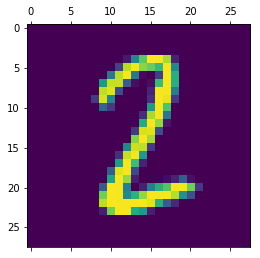

In [5]:
plt.matshow(data_labeled['image'][0, :, :])

In [6]:
slen = data_labeled['image'].shape[-1]

# Define VAE

In [11]:
latent_dim = 2
n_classes = 10

In [12]:
vae = mnist_vae_lib.HandwritingVAE(latent_dim = latent_dim, 
                                    n_classes = n_classes)

In [34]:
# Load results

enc_file = "../mnist_vae_results_aws/mnist_vae_semisupervised_ld2_enc_epoch160"
dec_file = '../mnist_vae_results_aws/mnist_vae_semisupervised_ld2_dec_epoch160'
classifier_file = '../mnist_vae_results_aws/mnist_vae_semisupervised_ld2_classifier_epoch160'

# enc_file = "../mnist_vae_results_aws/mnist_vae_semisupervised_enc_final"
# dec_file = '../mnist_vae_results_aws/mnist_vae_semisupervised_dec_final'
# classifier_file = '../mnist_vae_results_aws/mnist_vae_semisupervised_classifier_final'

# enc_file = "../saved_vae_results//mnist_vae_semisuper_enc"
# dec_file = '../saved_vae_results/mnist_vae_semisuper_dec'
# classifier_file = '../saved_vae_results/mnist_vae_semisuper_classifier'

vae.encoder.load_state_dict(torch.load(enc_file,
                               map_location=lambda storage, loc: storage))

vae.decoder.load_state_dict(torch.load(dec_file,
                               map_location=lambda storage, loc: storage))

vae.classifier.load_state_dict(torch.load(classifier_file,
                               map_location=lambda storage, loc: storage))


vae.eval()

HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=4, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=9, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=12, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=1568, bias=True)
  )
)

In [35]:
print(vae.parameters)

<bound method Module.parameters of HandwritingVAE(
  (encoder): MLPEncoder(
    (fc1): Linear(in_features=794, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=4, bias=True)
  )
  (classifier): Classifier(
    (fc1): Linear(in_features=784, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=9, bias=True)
  )
  (decoder): MLPConditionalDecoder(
    (fc1): Linear(in_features=12, out_features=128, bias=True)
    (fc3): Linear(in_features=128, out_features=128, bias=True)
    (fc4): Linear(in_features=128, out_features=128, bias=True)
    (fc5): Linear(in_features=128, out_features=1568, bias=True)
  )
)>


# Check losses

In [36]:
reinforce_loss_array = np.loadtxt('../mnist_vae_results_aws/mnist_vae_semisuper_reinforceloss_array.txt')

classic_loss_array = np.loadtxt('../mnist_vae_results_aws/mnist_vae_semisupervisedloss_array.txt')

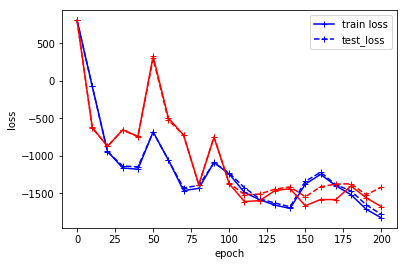

In [37]:
# reinforce losses
plt.plot(reinforce_loss_array[0, :], reinforce_loss_array[1, :], 'b-+')
plt.plot(reinforce_loss_array[0, :], reinforce_loss_array[2, :], 'b--+')

# classic losses
plt.plot(classic_loss_array[0, :], classic_loss_array[1, :], 'r-+')
plt.plot(classic_loss_array[0, :], classic_loss_array[2, :], 'r--+')

plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(('train loss', 'test_loss'))

In [38]:
vae.loss(data_unlabeled['image'])[0]

tensor(-1029.6519)

In [39]:
vae.loss(test_data['image'])[0]

tensor(-893.1442)

# Look at classification accuracies 

In [40]:
def get_classification_accuracy(loader, classifier, max_images = 1000): 
    n_images = 0.0
    accuracy = 0.0

    for batch_idx, data in enumerate(loader):
        class_weights = classifier(data['image'])

        z_ind = torch.argmax(class_weights, dim = 1)

        accuracy += torch.sum(z_ind == data['label']).float()
        # print(accuracy)

        n_images += len(z_ind)
        if n_images > 1000: 
            break

    return accuracy / n_images

In [41]:
class_weights = vae.classifier(data_unlabeled['image'])

In [42]:
get_classification_accuracy(train_loader_labeled, vae.classifier)

tensor(0.8931)

In [43]:
get_classification_accuracy(train_loader_unlabeled, vae.classifier)

tensor(0.8536)

In [44]:
get_classification_accuracy(test_loader, vae.classifier)

tensor(0.8545)

# Check reconstructions

In [45]:
# These are training images
class_weights = vae.classifier(data_unlabeled['image'])

z_ind = torch.argmax(class_weights, dim = 1)
z_ind_one_hot = common_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

latent_means, latent_std, latent_samples = \
    vae.encoder_forward(data_unlabeled['image'], z_ind_one_hot)

    
image_mu, image_std = vae.decoder_forward(latent_means, z_ind_one_hot)

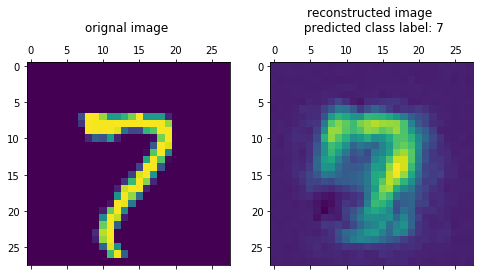

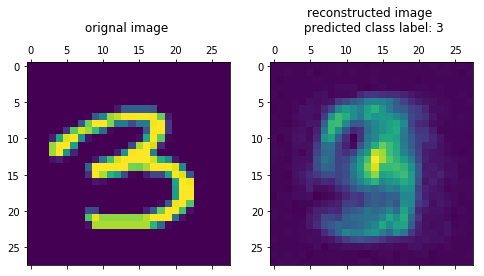

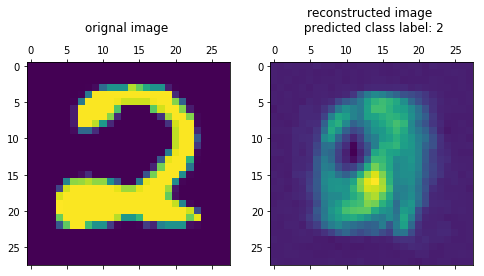

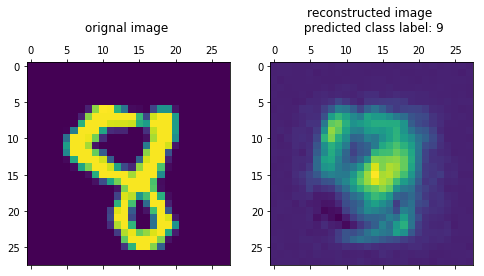

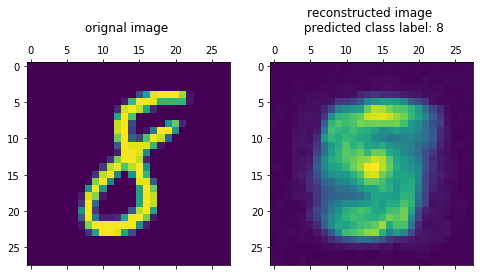

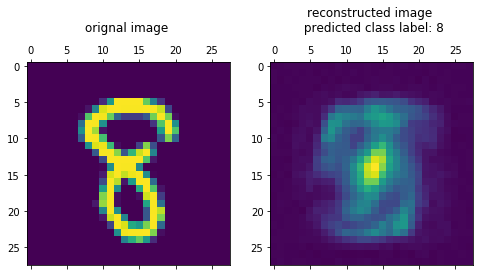

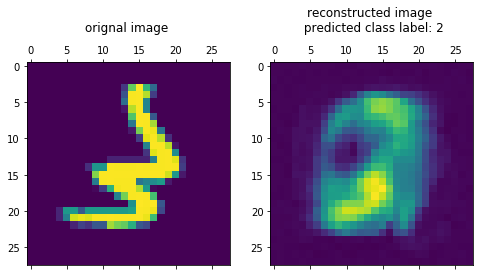

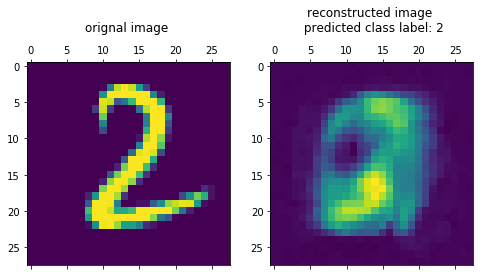

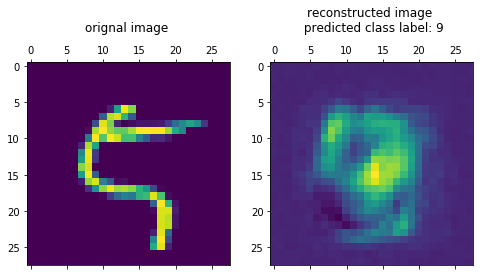

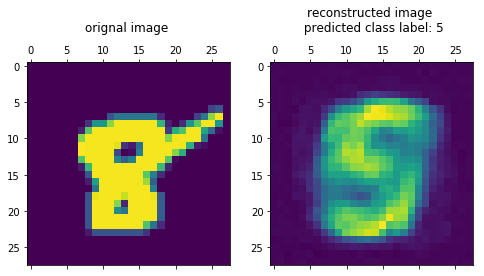

In [46]:
figsize = 8
for i in range(30, 40): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(data_unlabeled['image'][i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n ')
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z_ind[i]))

In [90]:
normal_loglik_z = common_utils.get_normal_loglik(data_unlabeled['image'], image_mu,
                                                image_std, scale = False)

(array([25., 57., 12.,  1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.,  1.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([-2818.85424805, -2169.04322103, -1519.23219401,  -869.42116699,
         -219.61013997,   430.20088704,  1080.01191406,  1729.82294108,
         2379.6339681 ,  3029.44499512,  3679.25602214,  4329.06704915,
         4978.87807617,  5628.68910319,  6278.50013021,  6928.31115723,
         7578.12218424,  8227.93321126,  8877.74423828,  9527.5552653 ,
        10177.36629232, 10827.17731934, 11476.98834635, 12126.79937337,
        12776.61040039, 13426.42142741, 14076.23245443, 14726.04348145,
        15375.85450846, 16025.66553548, 16675.4765625 ]),
 <a list of 30 Patch objects>)

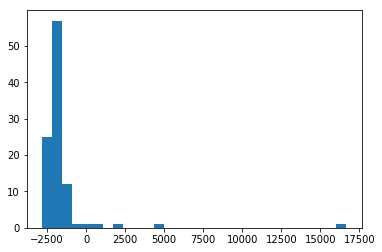

In [91]:
plt.hist(-normal_loglik_z.detach(), bins = 30)

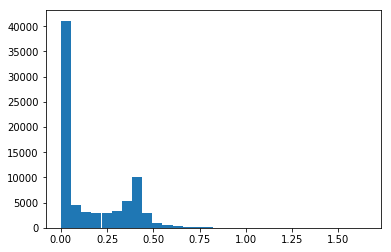

In [77]:
plt.hist(image_std.detach().numpy().flatten(), bins = 30);

In [78]:
# check a few test images 

In [79]:
class_weights = vae.classifier(test_data['image'])

z_ind = torch.argmax(class_weights, dim = 1)
z_ind_one_hot = common_utils.get_one_hot_encoding_from_int(z_ind, n_classes)

latent_means, latent_std, latent_samples = \
    vae.encoder_forward(data_unlabeled['image'], z_ind_one_hot)

    
image_mu, image_std = vae.decoder_forward(latent_means, z_ind_one_hot)

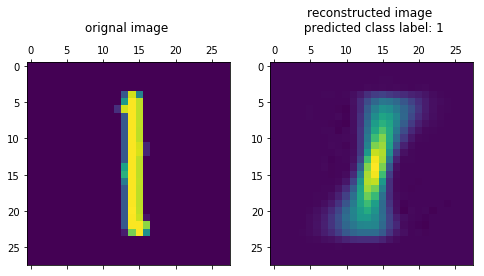

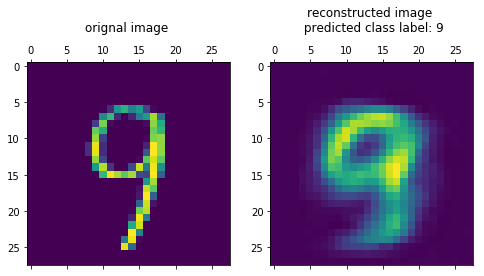

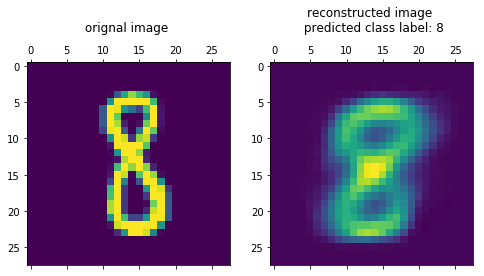

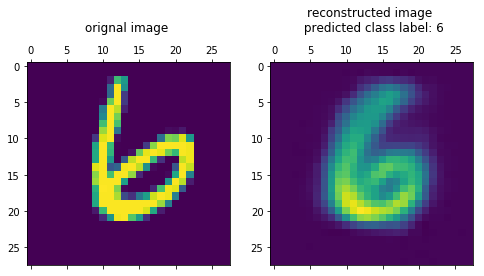

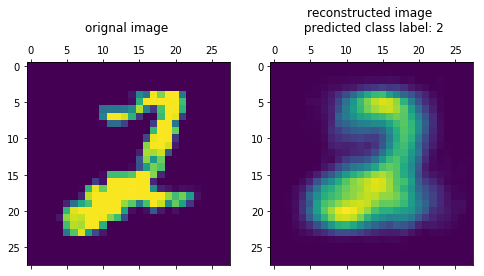

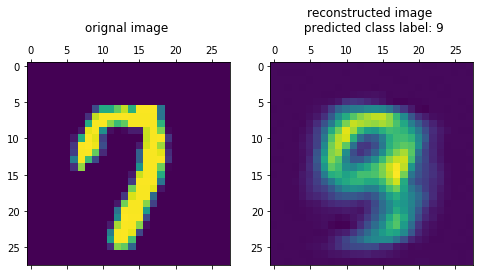

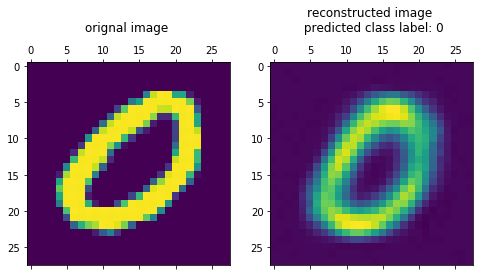

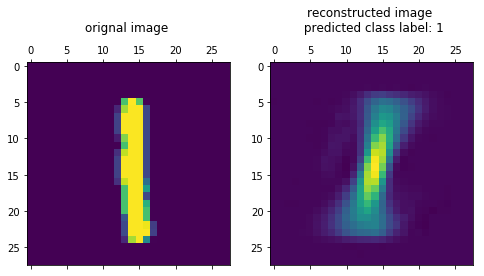

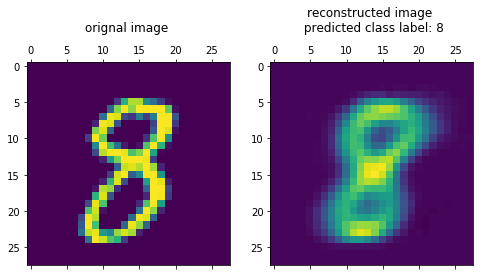

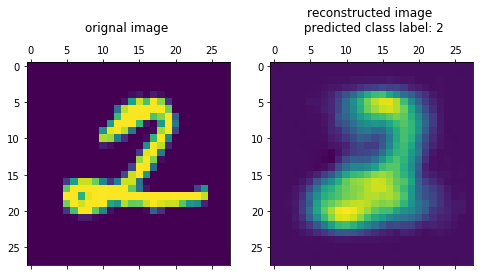

In [80]:
figsize = 8
for i in range(20, 30): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(test_data['image'][i, :, :])
    axarr[1].matshow(image_mu[i, :, :].detach())
    
    axarr[0].set_title('orignal image \n ')
    axarr[1].set_title('reconstructed image \n predicted class label: {}\n'.format(z_ind[i]))

In [81]:
normal_loglik_z = common_utils.get_normal_loglik(test_data['image'], image_mu,
                                                image_std, scale = False)

(array([93.,  1.,  2.,  0.,  0.,  0.,  0.,  1.,  0.,  1.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  1.]),
 array([ -2833.65234375,   5907.94492187,  14649.5421875 ,  23391.13945312,
         32132.73671875,  40874.33398438,  49615.93125   ,  58357.52851562,
         67099.12578125,  75840.72304687,  84582.3203125 ,  93323.91757812,
        102065.51484375, 110807.11210937, 119548.709375  , 128290.30664062,
        137031.90390625, 145773.50117187, 154515.0984375 , 163256.69570313,
        171998.29296875, 180739.89023437, 189481.4875    , 198223.08476562,
        206964.68203125, 215706.27929688, 224447.8765625 , 233189.47382812,
        241931.07109375, 250672.66835937, 259414.265625  ]),
 <a list of 30 Patch objects>)

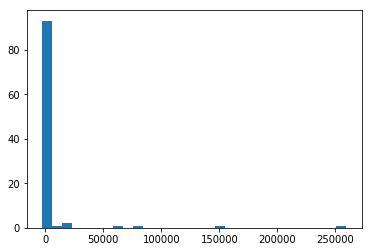

In [87]:
plt.hist(-normal_loglik_z.detach(), bins = 30)

In [23]:
foo = torch.rand((3, 5, 5))
foo_view = foo.view(-1, 25)

In [24]:
for i in range(foo.shape[0]): 
    a = torch.sum(foo[i, :, :] ** 2)
    b = torch.sum(foo[i, :] ** 2)
    print('a: {}, b: {}'.format(a, b))
    assert a == b

a: 8.61171817779541, b: 8.61171817779541
a: 9.121781349182129, b: 9.121781349182129
a: 7.090608596801758, b: 7.090608596801758
